
# 分子动力学中的系综、热浴和压浴

## 引言

分子动力学（Molecular Dynamics, MD）模拟是研究原子和分子运动的强大工具。在 MD 模拟中，选择合适的**系综**、**热浴**和**压浴**对于准确模拟系统至关重要。

本笔记本将系统地介绍分子动力学中的常见系综、热浴方法和压浴方法，提供数学公式和代码示例，以帮助理解它们的原理和应用。



## 分子动力学中的常见系综

在统计力学中，系综是描述系统可能状态的集合。不同的系综对应于不同的守恒量。

### 1. 微正则系综（Microcanonical Ensemble, NVE）

- **描述**：粒子数 $N$、体积 $V$ 和能量 $E$ 保持不变。
- **应用**：模拟与外界无能量交换的孤立系统。

总能量 $E$ 保持守恒：

$$
E = \sum_{i=1}^{N} \left( \frac{1}{2} m_i v_i^2 \right) + U(\mathbf{r}^N)
$$

其中：
- $m_i$ 为粒子 $i$ 的质量，
- $v_i$ 为粒子 $i$ 的速度，
- $U(\mathbf{r}^N)$ 为系统的势能，通常形式为 $U(\mathbf{r}^N) = \sum_{i < j} U(r_{ij})$。

### 2. 正则系综（Canonical Ensemble, NVT）

- **描述**：粒子数 $N$ 和体积 $V$ 保持不变，温度 $T$ 恒定。
- **应用**：模拟与热浴进行能量交换的系统。

使用热浴控制温度，使系统达到热平衡。

### 3. 等压等温系综（Isothermal-Isobaric Ensemble, NPT）

- **描述**：粒子数 $N$ 保持不变，压力 $P$ 和温度 $T$ 恒定。
- **应用**：模拟实际条件下的物理系统，如材料在恒压恒温下的行为。

需要热浴和压浴来同时控制温度和压力。



## 分子动力学中的热浴（Thermostats）

热浴用于在模拟中维持恒定的温度，通过调整粒子速度或引入额外变量来实现。下面将介绍几种常用的热浴方法及其原理。



### 1. Berendsen 热浴

- **原理**：通过指数衰减方式，将系统温度拉回目标温度。
- **算法**：

每个时间步，速度被缩放：

$$
\lambda = \sqrt{1 + \frac{\Delta t}{\tau_T} \left( \frac{T_0}{T} - 1 \right)}
$$

其中：
- $T$ 为瞬时温度，
- $\Delta t$ 为时间步长，
- $\tau_T$ 为温度耦合常数，
- $T_0$ 为目标温度。

**注意**：Berendsen 热浴不能产生正确的正则系综分布。


In [6]:
def berendsen_thermostat(v, T_current, T_target, tau_T, dt):
    lambda_T = np.sqrt(1 + (dt / tau_T) * (T_target / T_current - 1))
    return v * lambda_T



### 2. 速度重标（Velocity Rescaling）

- **原理**：直接将粒子速度缩放至目标温度。
- **算法**：

速度缩放因子为：

$$
\lambda = \sqrt{\frac{T_0}{T}}
$$

**注意**：会扰乱系统动力学，不生成真实的正则分布。


In [7]:
def velocity_rescaling(v, T_current, T_target):
    lambda_T = np.sqrt(T_target / T_current)
    return v * lambda_T



### 3. Nosé-Hoover 热浴

- **原理**：引入一个附加的摩擦项和虚拟热浴变量 $\xi$，实现对温度的精确控制。
- **运动方程**：

$$
\frac{d\mathbf{p}_i}{dt} = \mathbf{F}_i - \xi \mathbf{p}_i
$$

$$
\frac{d\xi}{dt} = \frac{1}{Q} \left( \sum_{i=1}^{N} \frac{\mathbf{p}_i^2}{m_i} - N k_B T_0 \right)
$$

其中：
- $\xi$ 为摩擦系数，
- $Q$ 为热浴的质量参数，
- $k_B$ 为玻尔兹曼常数，
- $T_0$ 为目标温度。

**注意**：Nosé-Hoover 热浴用于保持正则系综，但需要选择合适的 $Q$ 值以平衡温度。


In [8]:
def nose_hoover_thermostat(v, xi, Q, T_current, T_target, dt, N_atoms, k_B):
    # 更新速度
    v = v * np.exp(-xi * dt / 2)
    # 计算总动能
    K = 0.5 * np.sum(v**2) * (mass / N_atoms)
    # 更新摩擦系数
    xi += dt * ( (2 * K / (k_B * T_target)) - 1 ) / Q
    # 更新速度
    v = v * np.exp(-xi * dt / 2)
    return v, xi



### 4. Langevin 热浴

- **原理**：在运动方程中加入随机力和阻尼项，模拟与热浴的相互作用。
- **运动方程**：

$$
m_i \frac{d\mathbf{v}_i}{dt} = \mathbf{F}_i - \gamma m_i \mathbf{v}_i + \mathbf{R}_i(t)
$$

其中：
- $\gamma$ 为阻尼系数，用于调节粒子动能的衰减速度，
- $\mathbf{R}_i(t)$ 为满足波动-耗散定理的随机力。

**注意**：Langevin 热浴可用于研究耗散系统，如模拟液体分子的布朗运动。


In [9]:
def langevin_thermostat(v, gamma, T_target, mass, k_B, dt):
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt( (1 - c1**2) * k_B * T_target / mass )
    return c1 * v + c2 * np.random.randn(len(v))



## 压浴（Barostats）

为了保持系统在恒压条件下，可以使用压浴方法来控制系统的体积。这里介绍常见的 Berendsen 压浴和 Parrinello-Rahman 压浴。

### 1. Berendsen 压浴

通过对系统体积施加指数控制，使系统压力逐渐达到目标压力。

### 2. Parrinello-Rahman 压浴

允许系统的形状和体积自由变化，适合用于晶体结构模拟，可以反映真实条件下的晶格变形。


In [10]:
def berendsen_barostat(V, P_current, P_target, kappa, dt, tau_P):
    lambda_P = 1 - kappa * (P_current - P_target) * dt / tau_P
    return V * lambda_P


C:\Users\Gilbert\AppData\Local\Temp\ipykernel_26964\3590767499.py:9: RuntimeWarning: overflow encountered in exp
  v = v * np.exp(-xi * dt / 2)
C:\Users\Gilbert\AppData\Local\Temp\ipykernel_26964\3590767499.py:3: RuntimeWarning: overflow encountered in exp
  v = v * np.exp(-xi * dt / 2)
C:\Users\Gilbert\AppData\Local\Temp\ipykernel_26964\3590767499.py:9: RuntimeWarning: invalid value encountered in multiply
  v = v * np.exp(-xi * dt / 2)


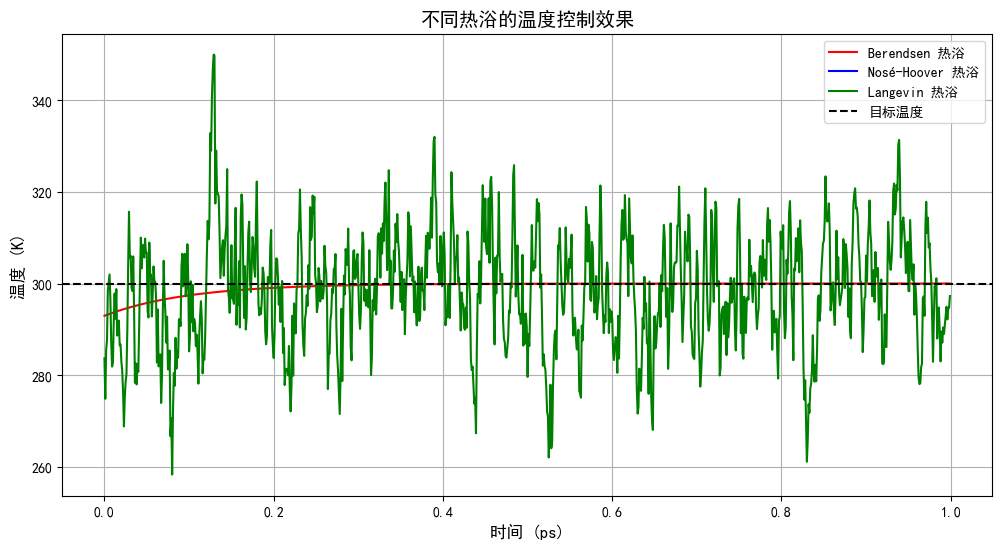

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 系统参数
N_atoms = 1000
T_target = 300  # 目标温度 (K)
mass = 1.66e-27  # 质量 (kg)
k_B = 1.38e-23  # 玻尔兹曼常数 (J/K)
dt = 1e-15  # 时间步长 (s)
time_steps = 1000
tau_T = 100 * dt

# 初始速度
np.random.seed(0)
v = np.random.randn(N_atoms) * np.sqrt(k_B * T_target / mass)

# 温度计算函数
def compute_temperature(v, mass, k_B):
    return np.mean(0.5 * mass * v**2) / (0.5 * k_B)

# 初始化不同热浴的温度存储
T_berendsen = []
T_nose_hoover = []
T_langevin = []

# Nosé-Hoover 参数初始化
Q = N_atoms * k_B * T_target * tau_T**2
xi = 0.0  # 初始摩擦系数
gamma = 0.1 / dt  # Langevin 热浴的阻尼系数

# 复制初始速度
v_b = v.copy()
v_n = v.copy()
v_l = v.copy()

# 模拟循环
for i in range(time_steps):
    # 当前温度
    T_current_b = compute_temperature(v_b, mass, k_B)
    T_current_n = compute_temperature(v_n, mass, k_B)
    T_current_l = compute_temperature(v_l, mass, k_B)
    
    # Berendsen 热浴
    v_b = berendsen_thermostat(v_b, T_current_b, T_target, tau_T, dt)
    T_berendsen.append(compute_temperature(v_b, mass, k_B))
    
    # Nosé-Hoover 热浴
    v_n, xi = nose_hoover_thermostat(v_n, xi, Q, T_current_n, T_target, dt, N_atoms, k_B)
    T_nose_hoover.append(compute_temperature(v_n, mass, k_B))
    
    # Langevin 热浴
    v_l = langevin_thermostat(v_l, gamma, T_target, mass, k_B, dt)
    T_langevin.append(compute_temperature(v_l, mass, k_B))

# 时间轴转换为皮秒
time = np.arange(time_steps) * dt * 1e12  # (ps)

# 绘制温度控制效果
plt.figure(figsize=(12, 6))
plt.plot(time, T_berendsen, label="Berendsen 热浴", color='r')
plt.plot(time, T_nose_hoover, label="Nosé-Hoover 热浴", color='b')
plt.plot(time, T_langevin, label="Langevin 热浴", color='g')
plt.axhline(T_target, color='k', linestyle='--', label="目标温度")
plt.xlabel('时间 (ps)', fontsize=12)
plt.ylabel('温度 (K)', fontsize=12)
plt.title('不同热浴的温度控制效果', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
